In [2]:
import essentia.standard as ess
import librosa as lib
import numpy as np
import matplotlib.pyplot as plt
import HTKPython as HTK
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from essentia import Pool
from scipy import pi
from scipy.io import savemat

In [3]:
########### extract filterbank with htk
URImfcFile = 'HTK/vignesh.mfc_no_preemph'

HTKFeat_reader =  HTK.htk_open(URImfcFile, 'rb')
htkMFCC = HTKFeat_reader.getall()
htkMFCC = htkMFCC.T
htkMFCC =htkMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]
URImfcFile = 'HTK/vignesh.fbank_no_preemf'
HTKFeat_reader =  HTK.htk_open(URImfcFile, 'rb')
htkMelBands = HTKFeat_reader.getall()

In [4]:
# configure essentia algorythms
bands = 26
coefficients = 13
liftering = 22
dctEssentia = ess.DCT(inputSize = bands,
                       outputSize=coefficients, 
                       dctType = 3, 
                       liftering = liftering)                    

pool = Pool()

In [5]:
pool.clear()

#essentia computing
for melBands in htkMelBands: 
    pool.add('DCT', dctEssentia(melBands))

essentiaMFCC = np.array(pool['DCT'].T);  



#librosa computing
librosaMFCC = lib.feature.mfcc(y=None, sr=44100, S=htkMelBands.T, n_mfcc=coefficients)


# liftering added manually to librosa
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]



Here I compute MFCC fromt he HTK melBands in Essentia.

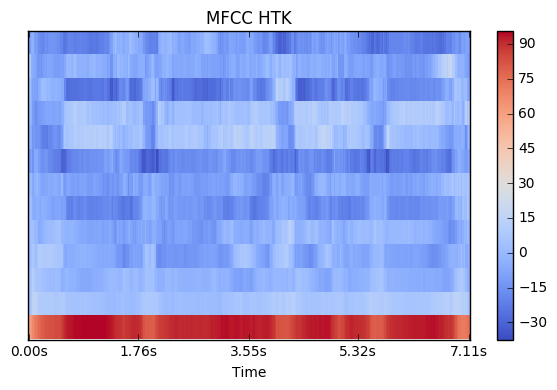

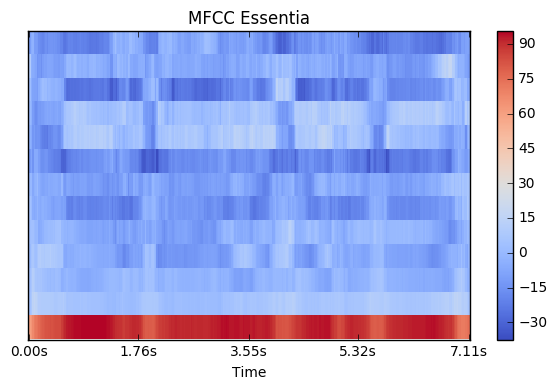

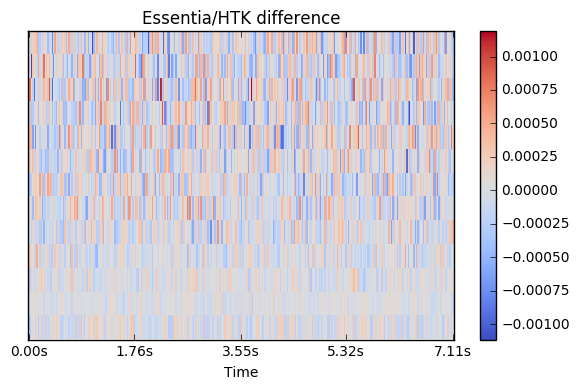

In [6]:
# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()

# Ploting Essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Essentia')
plt.tight_layout()
plt.show()

# Ploting Essentia / HTK difference
lib.display.specshow(essentiaMFCC- htkMFCC, x_axis='time')
plt.colorbar()
plt.title('Essentia/HTK difference')
plt.tight_layout()
plt.show()

Code below is a summary of the steps done until obtinig the final version.

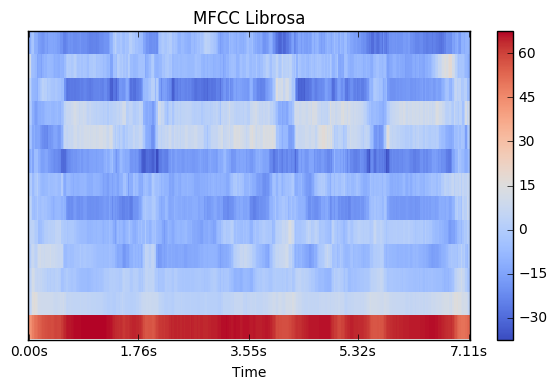

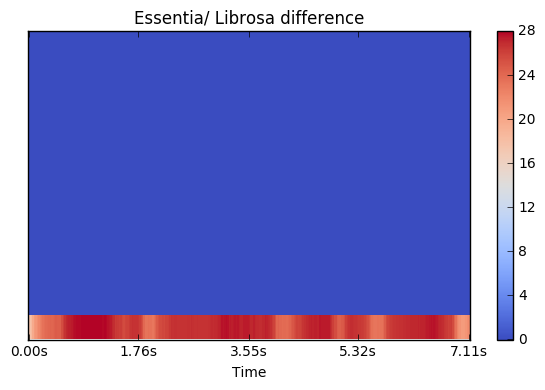

In [7]:
# Ploting Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Librosa')
plt.tight_layout()
plt.show()



# Ploting Essentia / Librosa difference
lib.display.specshow(essentiaMFCC- librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('Essentia/ Librosa difference')
plt.tight_layout()
plt.show()

Here there is some experimentation traying to understand if there is any difference in the way Librosa and HTK  computes the DCT. I try to compute the DCT III following the HTK book formula literally (As found in Robust AudioProcessor) instead of the Librosa way and I got different results but I can't understand why. However this suggests that probably we can't asume that librosa DCT III is the same as HTK. 

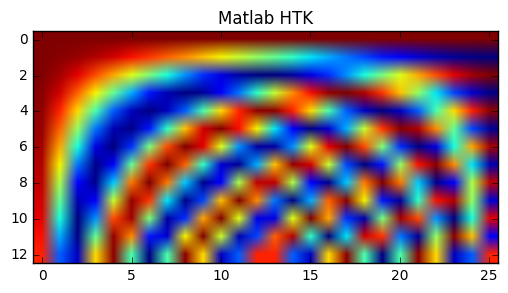

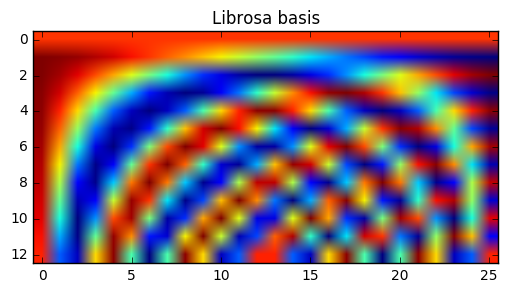

0.277350098113
0.277350098113


In [6]:
# dct bassis HTK formula
basis1 = np.ones((coefficients, bands))

for i in range(0, coefficients):
    for j in range (0, bands):
        basis1[i, j] = np.sqrt(2.0/bands) * np.cos((pi/bands)*(i)* (j+0.5)) 

plt.imshow(basis1)
plt.title('Matlab HTK')
plt.show()

basis = np.empty((coefficients, bands))
basis[0, :] = 1.0 / np.sqrt(bands)

samples = np.arange(1, 2*bands, 2) * np.pi / (2.0 * bands)

for i in range(1, coefficients):
    basis[i, :] = np.cos(i*samples) * np.sqrt(2.0/bands)

plt.imshow(basis)
plt.title('Librosa basis')
plt.show()

print basis1[0,0]
print basis[0,0] * np.sqrt(2)

In [7]:
print librosaMFCC[:,1]
print ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,1]
print ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) 

[ 43.02364952   4.97117083   3.791591     0.67709297   3.01156028
   4.24792545  -0.40864644 -11.38136633  -3.52025238   0.29489133
   3.02275689  10.34933036 -10.31311413]
[  43.02364952   12.75335594   15.54195188    3.7711134    20.9214568
   34.8477208    -3.80582458 -116.7021273   -38.74372852    3.40729913
   35.93464234  124.19196429 -122.60267063]
[  1.           2.56546322   4.09905813   5.56956514   6.94704899
   8.20346807   9.31324532  10.25378886  11.00595195  11.55442271
  11.88803586  12.          11.88803586]


(13, 307)


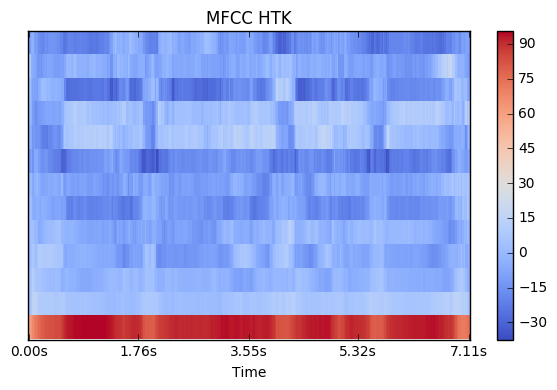

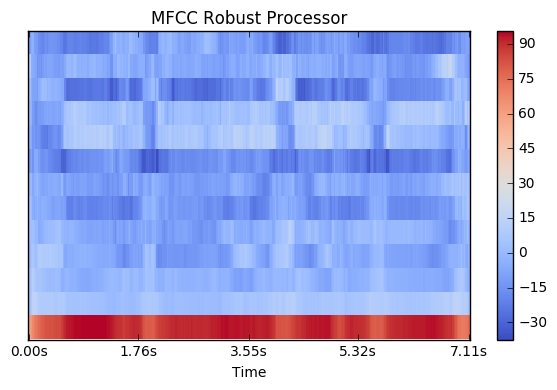

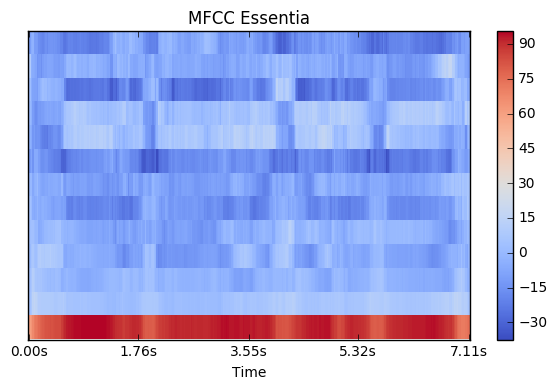

In [13]:
print librosaMFCC.shape
librosaMFCC =np.dot(basis1, (htkMelBands.T))
# liftering added manually to librosa
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]

# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()
    
# Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Robust Processor')
plt.tight_layout()
plt.show()

# Ploting Essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Essentia')
plt.tight_layout()
plt.show()


In [9]:
savemat('htkdata.mat', dict(enumerate(htkMelBands)))

TypeError: 'int' object has no attribute '__getitem__'